In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
import cv2
import umap

c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Convert to NumPy
X_train = train_dataset.data.numpy().astype("float64")
y_train = train_dataset.targets.numpy()

X_test  = test_dataset.data.numpy().astype("float64")
y_test  = test_dataset.targets.numpy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [3]:
# ✅ Normalize [0, 255] → [0, 1]
X_train /= 255.0
X_test  /= 255.0

# ✅ Add Gaussian noise N(0, 0.01)
noise_train = np.random.normal(0, 0.01, X_train.shape).astype("float64")
noise_test  = np.random.normal(0, 0.01, X_test.shape ).astype("float64")

X_train_noisy = X_train + noise_train
X_test_noisy  = X_test  + noise_test

# ✅ Clip to valid range
X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy  = np.clip(X_test_noisy, 0.0, 1.0)

In [4]:
def show_sample(X, y, index=0):
    """
    X: numpy array of shape (N, 28, 28)
    y: numpy labels of shape (N,)
    index: which sample to display
    """
    image = X[index]
    label = y[index]
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

In [5]:
def resize_to_16x16(X):
    X_resized = np.zeros((X.shape[0], 16, 16), dtype=np.float32)
    for i in range(X.shape[0]):
        X_resized[i] = cv2.resize(X[i], (16, 16), interpolation=cv2.INTER_AREA)
    return X_resized

In [6]:
X_train_16 = resize_to_16x16(X_train_noisy)
X_test_16  = resize_to_16x16(X_test_noisy)

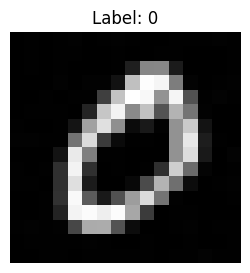

In [7]:
show_sample(X_train_16, y_train, index=1)

UMAP shape: (5000, 2)


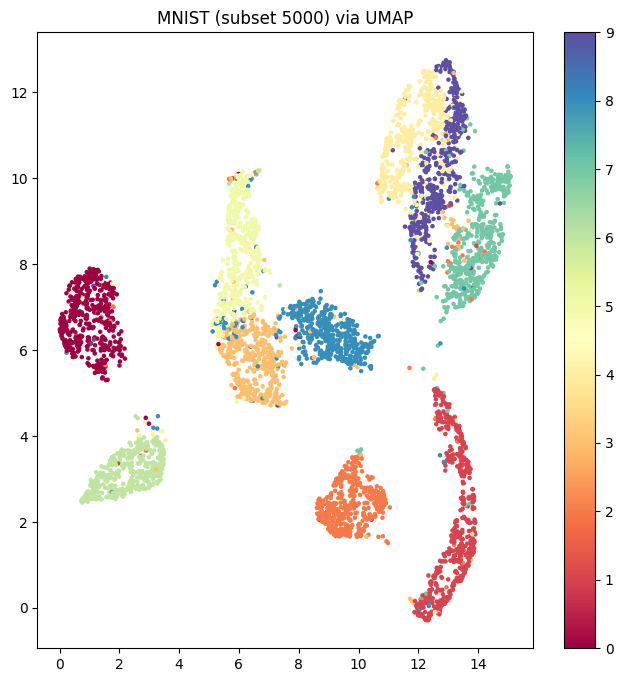

In [8]:
num_samples = 5000

# Random sample indices
idx = np.random.choice(len(X_train_16), num_samples, replace=False)

# Subset
X_sub = X_train_16[idx]
y_sub = y_train[idx]

# Flatten (num_samples, 16, 16) → (num_samples, 256)
X_sub_flat = X_sub.reshape(num_samples, -1)

# ----- UMAP -----
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean")
X_umap = reducer.fit_transform(X_sub_flat)

print("UMAP shape:", X_umap.shape)  # (num_samples, 2)

# ----- Plot -----
plt.figure(figsize=(8,8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_sub, s=5, cmap="Spectral")
plt.colorbar(scatter)
plt.title(f"MNIST (subset {num_samples}) via UMAP")
plt.show()

In [9]:
from dataset.datasets import getUSPS

In [10]:
USPS = getUSPS()
X_usps_train = USPS["Xtrain"]
y_usps_train = USPS["ytrain"]

X_usps_test = USPS["Xtest"]
y_usps_test = USPS["ytest"]


In [11]:
# # reshape 256 to 16x16
# X_usps_train_16 = X_usps_train.reshape(-1, 16, 16)
# X_usps_test_16 = X_usps_test.reshape(-1, 16, 16)

In [12]:
# USPS shapes
print("Raw:", X_usps_train.shape, y_usps_train.shape)

# ✅ reshape 256 → 16×16
X_usps_train_16 = X_usps_train.reshape(-1, 16, 16)
X_usps_test_16  = X_usps_test.reshape(-1, 16, 16)

print("Reshaped:", X_usps_train_16.shape, X_usps_test_16.shape)


Raw: (7291, 256) (7291,)
Reshaped: (7291, 16, 16) (2007, 16, 16)


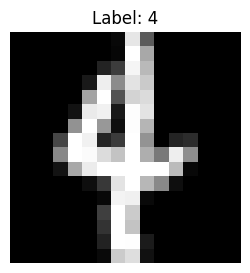

In [13]:
show_sample(X_usps_train_16, y_usps_train, index=20)

In [14]:

# ✅ sample subset
num_samples = 2000
idx = np.random.choice(len(X_usps_train_16), num_samples, replace=False)

X_sub = X_usps_train_16[idx]
y_sub = y_usps_train[idx]

# flatten for UMAP (N, 256)
X_sub_flat = X_sub.reshape(num_samples, -1)


UMAP shape: (2000, 2)


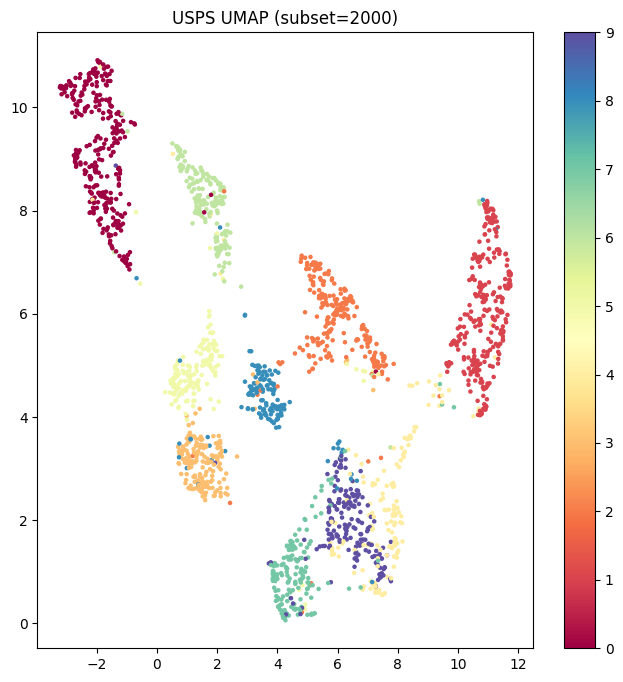

In [15]:

# ✅ UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean")
X_umap = reducer.fit_transform(X_sub_flat)

print("UMAP shape:", X_umap.shape)

# ✅ plot
plt.figure(figsize=(8,8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_sub, s=5, cmap="Spectral")
plt.colorbar(scatter)
plt.title(f"USPS UMAP (subset={num_samples})")
plt.show()

In [16]:
# MNIST is source, USPS is target
# dataset with vectorized images
X_source = X_train_16.reshape(-1, 256)
X_target = X_usps_train_16.reshape(-1, 256)


In [17]:
import os
import time
import yaml
import numpy as np
import torch
from torch.utils.data import TensorDataset
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import umap
from sklearn.manifold import TSNE
import pandas as pd
from models.wdgrl import WDGRL

In [18]:
y_source = y_train
y_target = y_usps_train

In [19]:
selected_label = [0, 1, 3, 8]

# Recreate source/target arrays from the original full datasets so masks align with labels.
# This avoids applying a boolean mask computed from a 60000-length y array to a possibly
# already-filtered X_source (which would cause the IndexError).
X_source = X_train_16.reshape(-1, 256)
y_source = y_train

X_target = X_usps_train_16.reshape(-1, 256)
y_target = y_usps_train

# Now compute masks and filter (lengths match)
source_indices = np.isin(y_source, selected_label)
target_indices = np.isin(y_target, selected_label)

X_source = X_source[source_indices]
y_source = y_source[source_indices]
X_target = X_target[target_indices]
y_target = y_target[target_indices]

In [20]:
ns, nt = X_source.shape[0], X_target.shape[0]
d = X_source.shape[1]

In [21]:
xs = torch.from_numpy(X_source).double()
xt = torch.from_numpy(X_target).double()

source_dataset = TensorDataset(xs)
target_dataset = TensorDataset(xt)

print(d)

256


In [22]:
# ==== WDGRL model ====
final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=[300,100],
    critic_hidden_dims=[100],
    alpha1=0.0005,
    alpha2=0.000005,
    seed=42,
)

In [23]:
# ==== Logging setup ====
timestamp = time.strftime("%Y%m%d-%H%M%S")+'-mnist-usps'
log_dir = os.path.join("logs", timestamp)
os.makedirs(log_dir, exist_ok=True)

log_file = os.path.join(log_dir, "results.txt")
log_loss = final_model.train(
    source_dataset,
    target_dataset,
    num_epochs=4000,
    gamma=0.5,
    dc_iter=6,
    batch_size=50,
    # early_stopping=True,
    model_path=log_dir,
)

Epoch:   0%|          | 0/4000 [00:00<?, ?it/s]c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch: 100%|██████████| 4000/4000 [01:50<00:00, 36.23it/s]


In [24]:
final_model.save_model(log_dir)

# ==== Save logs ====
total_loss = log_loss["loss"]

Encoder and Critic saved to logs\20251111-220822-mnist-usps


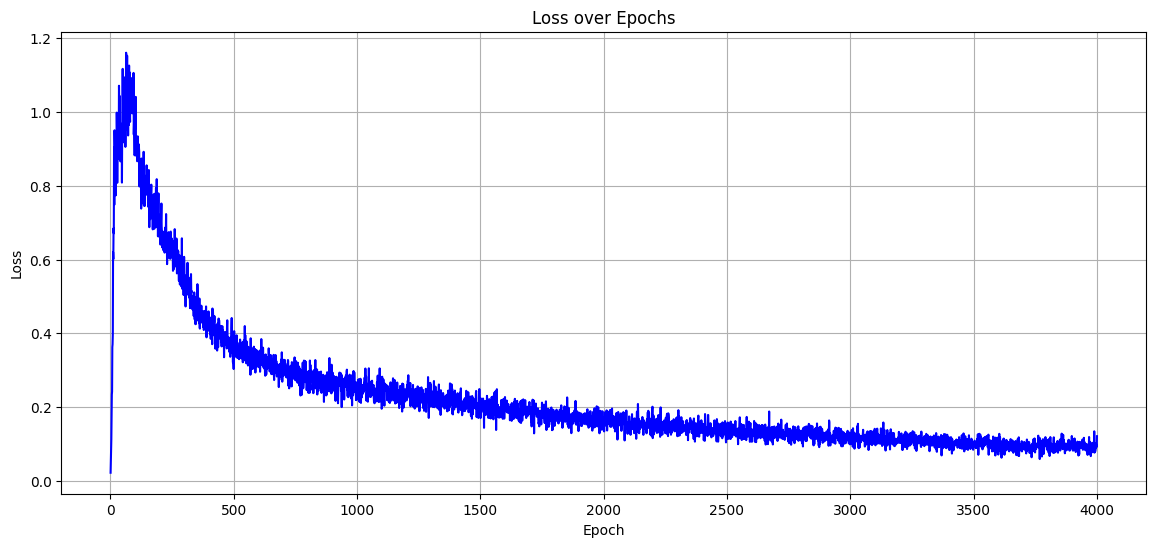

In [25]:
epochs = range(1, len(total_loss) + 1)

plt.figure(figsize=(14, 6))
plt.plot(epochs, total_loss, linestyle='-', color='blue')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim(0, 1.0)
plt.grid(True)
plt.savefig(os.path.join(log_dir, "loss.png"))
plt.show()
plt.close()

In [26]:
xs_hat = final_model.extract_feature(xs.cuda())
xt_hat = final_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

UMAP shape: (2000, 2)


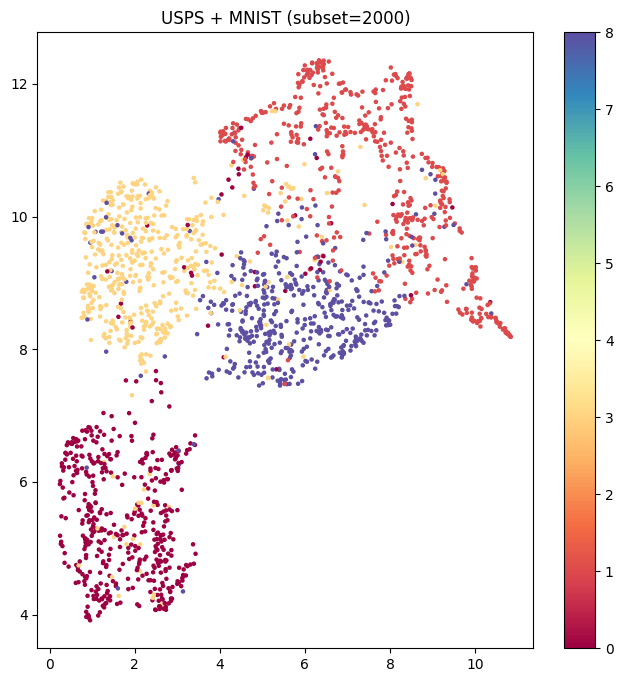

In [27]:
# Stack features and use the correct label arrays (source = y_train, target = y_usps_train)
X_all = np.vstack([xs_hat, xt_hat])
y_all = np.concatenate([y_source, y_target])

# Create domain labels (0=source, 1=target)
domain_all = np.concatenate([
    np.zeros(len(xs_hat), dtype=int),
    np.ones(len(xt_hat), dtype=int)
])

# sample subset for faster t-SNE (sample consistently from X, y and domain)
num_samples = 2000
indices = np.random.choice(X_all.shape[0], num_samples, replace=False)

X_sub = X_all[indices]
y_sub = y_all[indices]
domain_sub = domain_all[indices]

# ✅ UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean")
X_umap = reducer.fit_transform(X_sub)

print("UMAP shape:", X_umap.shape)

# ✅ plot
plt.figure(figsize=(8,8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_sub, s=5, cmap="Spectral")
plt.colorbar(scatter)
plt.title(f"USPS + MNIST (subset={num_samples})")
plt.show()